1. Introduction
We aim to predict **machine failures** using classical ML and deep learning.  
This helps manufacturers reduce downtime and costs.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import shap

2. Dataset Overview
Dataset: **AI4I Predictive Maintenance Dataset** (~10k rows, 7 key features + target).  
Target: `Machine Failure` (binary classification).

In [8]:

df = pd.read_csv('/content/ai4i2020.csv')
print("AI4I dataset shape:", df.shape)
display(df.head())

AI4I dataset shape: (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [ ]:
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [ ]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [ ]:
print(df["Machine failure"].value_counts())


0    9661
1     339
Name: Machine failure, dtype: int64


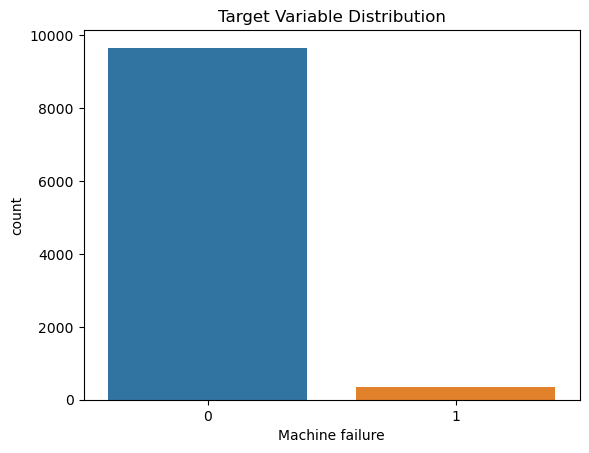

In [ ]:
sns.countplot(x="Machine failure", data=df)
plt.title("Target Variable Distribution")
plt.show()

3. Data Preprocessing
- Dropped irrelevant IDs  
- Encoded categorical feature (`Type`)  
- Standardized continuous features  
- Applied **SMOTE** for balancing classes  

In [9]:
# Removing unnecessary and leakage causing features from data
df.drop(columns=['UDI','Product ID'],axis=1,inplace=True)
df.drop(columns=['TWF','HDF','PWF','OSF','RNF'],inplace=True)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


In [10]:
df['Type'] = LabelEncoder().fit_transform(df['Type'])

In [11]:
df['Temp Diff'] = df['Process temperature [K]'] - df['Air temperature [K]']

In [12]:
# Select Features & Target
X = df[['Air temperature [K]', 'Process temperature [K]', 'Type',
        'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Temp Diff']]
y = df['Machine failure']


In [13]:
# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
print("Standardized Features Preview:")
display(X_scaled_df.head())

Standardized Features Preview:


,Air temperature [K],Process temperature [K],Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Temp Diff
0,-0.952389,-0.947360,1.333889,0.068185,0.282200,-1.695984,0.498849
1,-0.902393,-0.879959,-0.332223,-0.729472,0.633308,-1.648852,0.498849
2,-0.952389,-1.014761,-0.332223,-0.227450,0.944290,-1.617430,0.398954
3,-0.902393,-0.947360,-0.332223,-0.590021,-0.048845,-1.586009,0.398954
4,-0.902393,-0.879959,-0.332223,-0.729472,0.001313,-1.554588,0.498849


In [15]:
# Check Target Distribution
from collections import Counter

print("Target counts before SMOTE:", Counter(y))

Target counts before SMOTE: Counter({0: 9661, 1: 339})


In [16]:
#  Handle Class Imbalance using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled_df, y)

print("Target counts after SMOTE:", Counter(y_res))

Target counts after SMOTE: Counter({0: 9661, 1: 9661})


In [17]:
#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                    test_size=0.2,
                                                    random_state=42)

4. Modeling

In [18]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

# Clean feature names for XGBoost (no [] <> allowed)
X_train.columns = [c.replace(" ", "_")
                    .replace("[","")
                    .replace("]","")
                    .replace("<","lt")
                    .replace(">","gt")
                   for c in X_train.columns]
X_test.columns = X_train.columns

models = {
    "LogisticRegression": LogisticRegression(C=1.0, penalty="l2", solver="liblinear", max_iter=500),
    "Random Forest"     : RandomForestClassifier(),
    "XGBoost"           : XGBClassifier(eval_metric='logloss', random_state=42),
    "KNN"               : KNeighborsClassifier(),
    "SVC"               : SVC()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = {"Accuracy": acc, "F1 Score": f1}

comparison_df = pd.DataFrame(results).T
print(comparison_df)


                    Accuracy  F1 Score
LogisticRegression  0.823286  0.822274
Random Forest       0.988098  0.988144
XGBoost             0.990427  0.990476
KNN                 0.964295  0.965379
SVC                 0.948512  0.949428


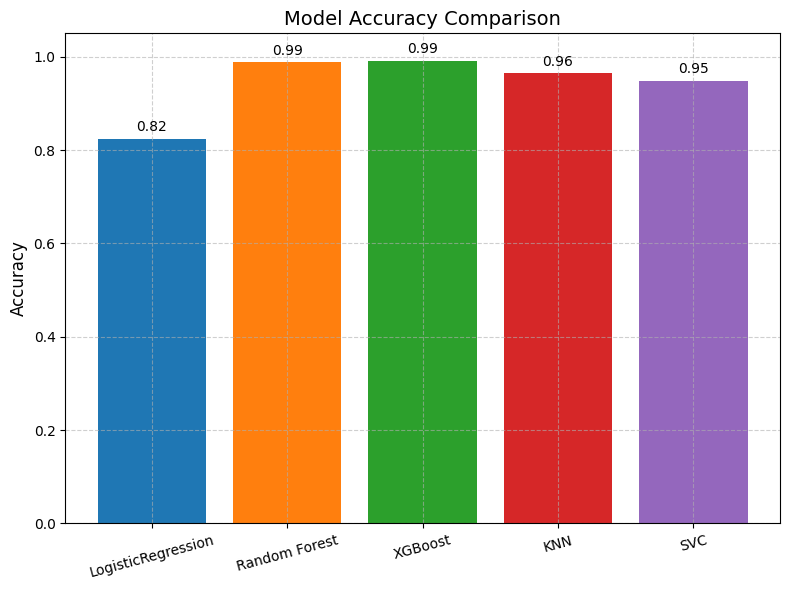

In [19]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt



# Lists to store names and accuracy
model_names = []
accuracy_scores = []
# Loop to calculate accuracy
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    model_names.append(name)
    accuracy_scores.append(acc)

# Set a color palette (can also use sns.color_palette())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Add more if needed

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, accuracy_scores, color=colors[:len(models)])
plt.ylim(0, 1.05)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=15, fontsize=10)

# Annotate each bar
for bar, acc in zip(bars, accuracy_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{acc:.2f}', ha='center', va='bottom', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [20]:
# cross validation for checking the average percentage of models score
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import numpy as np

# Clean feature names
X_res.columns = [c.replace(" ", "_")
                  .replace("[","")
                  .replace("]","")
                  .replace("<","lt")
                  .replace(">","gt")
                 for c in X_res.columns]

# Define model
model = XGBClassifier(eval_metric="logloss", random_state=42)

# Cross-validation
scores = cross_val_score(model, X_res, y_res, cv=5, scoring='accuracy')
print("Cross validation Accuracy scores:", scores)
print("Mean Accuracy:", np.mean(scores))



Cross validation Accuracy scores: [0.97128072 0.95730918 0.83669772 0.97412008 0.98291925]
Mean Accuracy: 0.9444653938970268


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1934
           1       0.98      1.00      0.99      1931

    accuracy                           0.99      3865
   macro avg       0.99      0.99      0.99      3865
weighted avg       0.99      0.99      0.99      3865

[[1904   30]
 [   7 1924]]


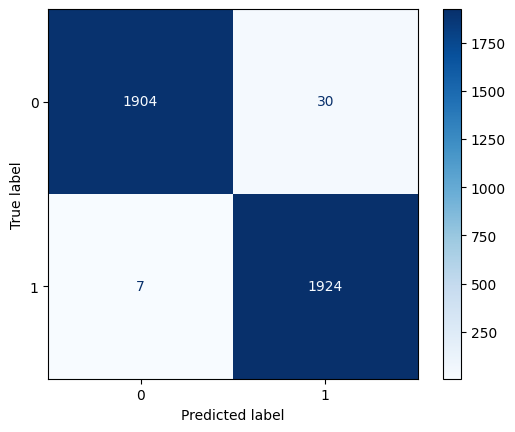

In [21]:
# confuson matrix for checking how much actually it is doing right and wrong

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
print(classification_report(y_test, y_pred))
print(cm)

"Although tree-based models (like XGBoost) outperformed all others, a baseline dense neural network was also evaluated for completeness and comparison with deep learning approaches."

🧩 Step 1: Imports

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np



In [22]:
#Build the DNN model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
from tensorflow.keras.optimizers import Adam
#  Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=2
)

Epoch 1/50
194/194 - 4s - 19ms/step - accuracy: 0.8175 - loss: 0.4018 - val_accuracy: 0.8917 - val_loss: 0.2886
Epoch 2/50
194/194 - 1s - 3ms/step - accuracy: 0.8872 - loss: 0.2716 - val_accuracy: 0.9107 - val_loss: 0.2002
Epoch 3/50
194/194 - 1s - 3ms/step - accuracy: 0.9075 - loss: 0.2392 - val_accuracy: 0.9308 - val_loss: 0.1679
Epoch 4/50
194/194 - 1s - 3ms/step - accuracy: 0.9128 - loss: 0.2189 - val_accuracy: 0.9411 - val_loss: 0.1541
Epoch 5/50
194/194 - 1s - 7ms/step - accuracy: 0.9171 - loss: 0.2074 - val_accuracy: 0.9499 - val_loss: 0.1409
Epoch 6/50
194/194 - 1s - 5ms/step - accuracy: 0.9234 - loss: 0.1986 - val_accuracy: 0.9437 - val_loss: 0.1400
Epoch 7/50
194/194 - 1s - 5ms/step - accuracy: 0.9288 - loss: 0.1862 - val_accuracy: 0.9505 - val_loss: 0.1304
Epoch 8/50
194/194 - 1s - 4ms/step - accuracy: 0.9320 - loss: 0.1779 - val_accuracy: 0.9531 - val_loss: 0.1246
Epoch 9/50
194/194 - 1s - 3ms/step - accuracy: 0.9326 - loss: 0.1730 - val_accuracy: 0.9554 - val_loss: 0.1251


In [25]:
#  Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {accuracy:.4f}")

#  Predictions and further metrics
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

121/121 - 0s - 2ms/step - accuracy: 0.9614 - loss: 0.0985
Test Accuracy: 0.9614
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1934
           1       0.94      0.98      0.96      1931

    accuracy                           0.96      3865
   macro avg       0.96      0.96      0.96      3865
weighted avg       0.96      0.96      0.96      3865

Confusion Matrix:
 [[1822  112]
 [  37 1894]]


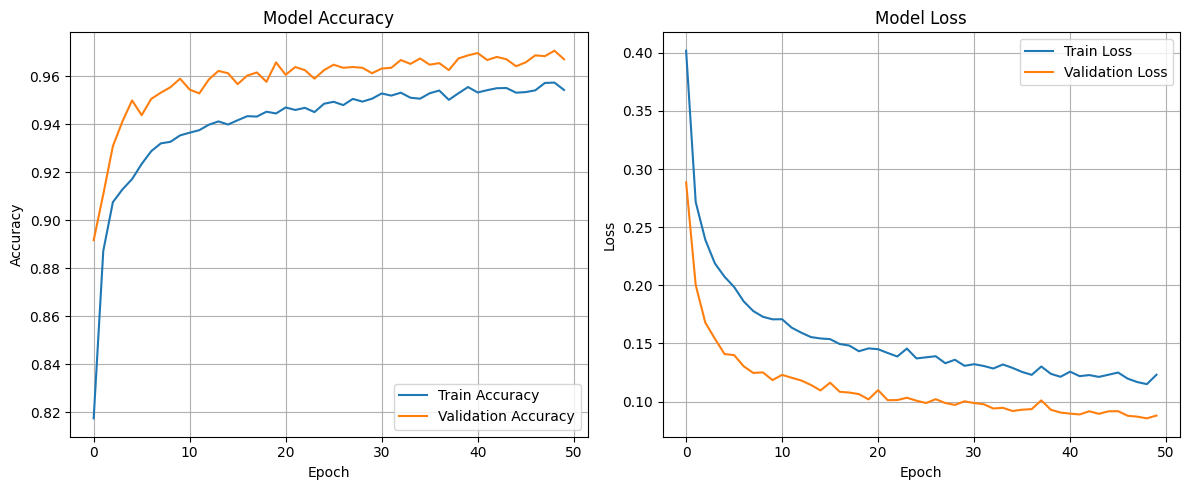

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
